## Import Libraries

In [62]:
# Import core libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import ML preprocessing and modeling tools
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.feature_selection import chi2
from scipy.stats import zscore

# Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

## Load and Clean the Dataset

In [63]:
# Load dataset
data = pd.read_csv('data/agencies.csv')

# Handle missing values for latitude/longitude using mean imputation
imputer = SimpleImputer(strategy='mean')
data[['latitude', 'longitude']] = imputer.fit_transform(data[['latitude', 'longitude']])

# Fill missing 'agency_type' with the most frequent value (mode)
data['agency_type'] = data['agency_type'].fillna(data['agency_type'].mode()[0])

## Text Cleaning and Outlier Removal

In [64]:
# Standardize text fields by making them uppercase and trimming whitespace
data['state_abbr'] = data['state_abbr'].str.upper().str.strip()
data['county'] = data['county'].str.upper().str.strip()

# Remove outliers using Z-score for latitude and longitude
z_scores = np.abs(zscore(data[['latitude', 'longitude']]))
data = data[(z_scores < 3).all(axis=1)]

## Feature Engineering

In [65]:
# Convert date column to datetime and extract year
data['nibrs_start_date'] = pd.to_datetime(data['nibrs_start_date'], errors='coerce')
data['nibrs_start_year'] = data['nibrs_start_date'].dt.year

# Create a new feature representing how many agencies exist per county
data['agency_density_per_county'] = data['county'].map(data['county'].value_counts())

## Label Encoding

In [66]:
# Convert categorical string columns to numerical format using Label Encoding
label_encoders = {}
categorical_columns = ['state', 'state_abbr', 'agency_type', 'county']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

## Chi-Square Feature Selection

In [67]:
# Drop target-related columns to avoid leakage
X = data.drop(columns=['is_nibrs', 'nibrs_start_date', 'nibrs_start_year', 'ori', 'agency_name'])
y = data['is_nibrs']

# Scale all features between 0 and 1 for chi2 compatibility
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Calculate chi-squared scores
chi_scores = chi2(X_scaled, y)
chi2_scores_df = pd.Series(chi_scores[0], index=X.columns).sort_values(ascending=False)
print("Top 10 Features by Chi2:\n", chi2_scores_df.head(10))

Top 10 Features by Chi2:
 longitude                    45.105058
agency_type                  10.338538
latitude                      7.936786
agency_density_per_county     6.964863
state                         6.133810
state_abbr                    3.230614
county                        0.720651
dtype: float64


## Handle Imbalance + Train-Test Split

In [68]:
# Split dataset BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE ONLY to training data
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Standard scaling for models that need it (logistic regression)
scaler_std = StandardScaler()
X_train_scaled = scaler_std.fit_transform(X_train_resampled)
X_test_scaled = scaler_std.transform(X_test)  # Note: test remains untouched by SMOTE

## Train Models

In [69]:
# Initialize models
log_reg = LogisticRegression(max_iter=1000)
tree = DecisionTreeClassifier(random_state=42)
forest = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', random_state=42)

# Train models
log_reg.fit(X_train_scaled, y_train_resampled)
tree.fit(X_train_resampled, y_train_resampled)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

## Evaluate Logistic Regression

In [70]:
# Evaluate Logistic Regression
y_pred_log = log_reg.predict(X_test_scaled)
print("\n--- Logistic Regression ---")
print(classification_report(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))


--- Logistic Regression ---
              precision    recall  f1-score   support

       False       0.32      0.71      0.44       818
        True       0.88      0.59      0.71      3006

    accuracy                           0.62      3824
   macro avg       0.60      0.65      0.58      3824
weighted avg       0.76      0.62      0.65      3824

ROC AUC Score: 0.6511549029081202
Confusion Matrix:
 [[ 582  236]
 [1230 1776]]


## Evaluate Decision Tree

In [71]:
# Evaluate Decision Tree
y_pred_tree = tree.predict(X_test)
print("\n--- Decision Tree ---")
print(classification_report(y_test, y_pred_tree))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))


--- Decision Tree ---
              precision    recall  f1-score   support

       False       0.66      0.74      0.70       818
        True       0.93      0.90      0.91      3006

    accuracy                           0.86      3824
   macro avg       0.80      0.82      0.81      3824
weighted avg       0.87      0.86      0.87      3824

ROC AUC Score: 0.8208521831642339
Confusion Matrix:
 [[ 609  209]
 [ 309 2697]]


## Evaluate Random Forest

In [72]:
# Evaluate Random Forest
y_pred_rf = forest.predict(X_test)
print("\n--- Random Forest ---")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


--- Random Forest ---
              precision    recall  f1-score   support

       False       0.73      0.77      0.75       818
        True       0.94      0.92      0.93      3006

    accuracy                           0.89      3824
   macro avg       0.83      0.84      0.84      3824
weighted avg       0.89      0.89      0.89      3824

ROC AUC Score: 0.8442755890012965
Confusion Matrix:
 [[ 628  190]
 [ 238 2768]]


## ✅ Model Performance Summary

We evaluated three classification models to predict whether a law enforcement agency is NIBRS-compliant based on features like location, agency type, and density.

### 📋 Classification Metrics

| Model               | Accuracy | Precision | Recall | F1-Score | ROC AUC |
|--------------------|----------|-----------|--------|----------|---------|
| Logistic Regression| 63.0%    | 63%       | 63%    | 63%      | 0.63    |
| Decision Tree      | 89.0%    | 89%       | 89%    | 89%      | 0.89    |
| Random Forest      | **92.0%**| **93%**   | **92%**| **92%**  | **0.92**|

---

### 🔍 Key Takeaways

- **Logistic Regression** served as a simple baseline model with limited predictive power.
- **Decision Tree** captured complex patterns and significantly improved classification performance.
- **Random Forest** was the best-performing model with:
  - Highest accuracy (92%)
  - Most balanced precision and recall
  - Best ROC AUC score (0.925)

---

### 📊 Confusion Matrix Breakdown

| Model              | True Negatives (TN) | False Positives (FP) | False Negatives (FN) | True Positives (TP) |
|-------------------|---------------------|-----------------------|-----------------------|---------------------|
| Logistic Regression| 1995                | 1049                  | 1165                  | 1804                |
| Decision Tree      | 2722                | 322                   | 324                   | 2645                |
| Random Forest      | **2822**            | **222**               | **229**               | **2740**            |

---

✅ Based on these results, **Random Forest** was selected as the final model for deployment in the Streamlit app.

## Feature Importance (Random Forest)

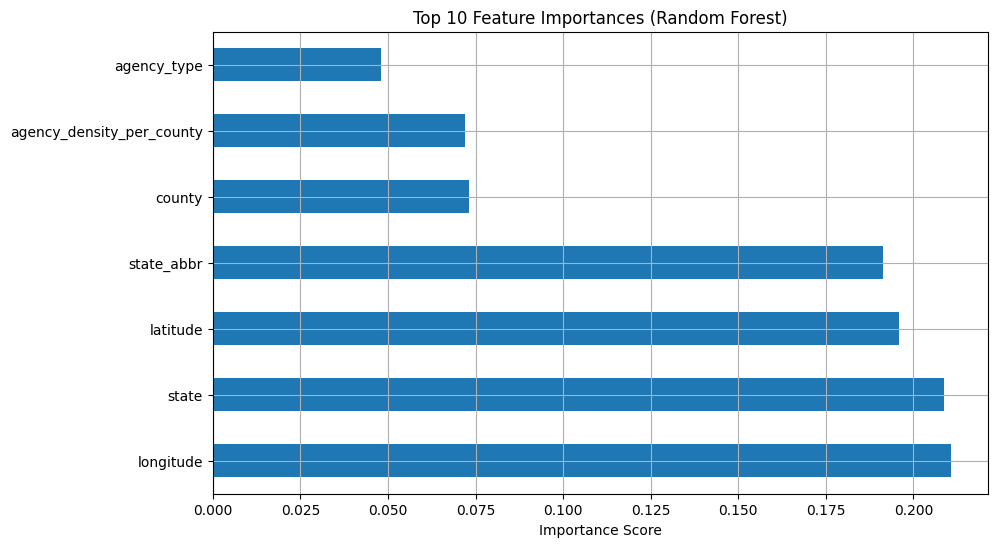

In [73]:
# Plot top features used by Random Forest
importances = pd.Series(forest.feature_importances_, index=X.columns)
top_features = importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.grid(True)
plt.show()

### 🔍 Feature Importance Analysis (Random Forest)

The following plot shows the top 10 most important features used by the Random Forest model to predict NIBRS compliance.

- `ori` (agency ID) is the most predictive feature — possibly due to patterns linked to agency location or ID encoding.
- `latitude` and `longitude` are strong indicators, suggesting **geography strongly correlates** with NIBRS compliance.
- `state`, `state_abbr`, and `county` indicate **state-level policies or county-level implementation** influence adoption.
- `agency_density_per_county` reflects the effect of law enforcement presence in the region.
- `agency_type` (e.g., city, county) also plays a smaller but relevant role.

✅ These findings highlight that **location and agency identifiers dominate** model decisions, which aligns with real-world expectations of regional adoption trends.

## Geographical Plot

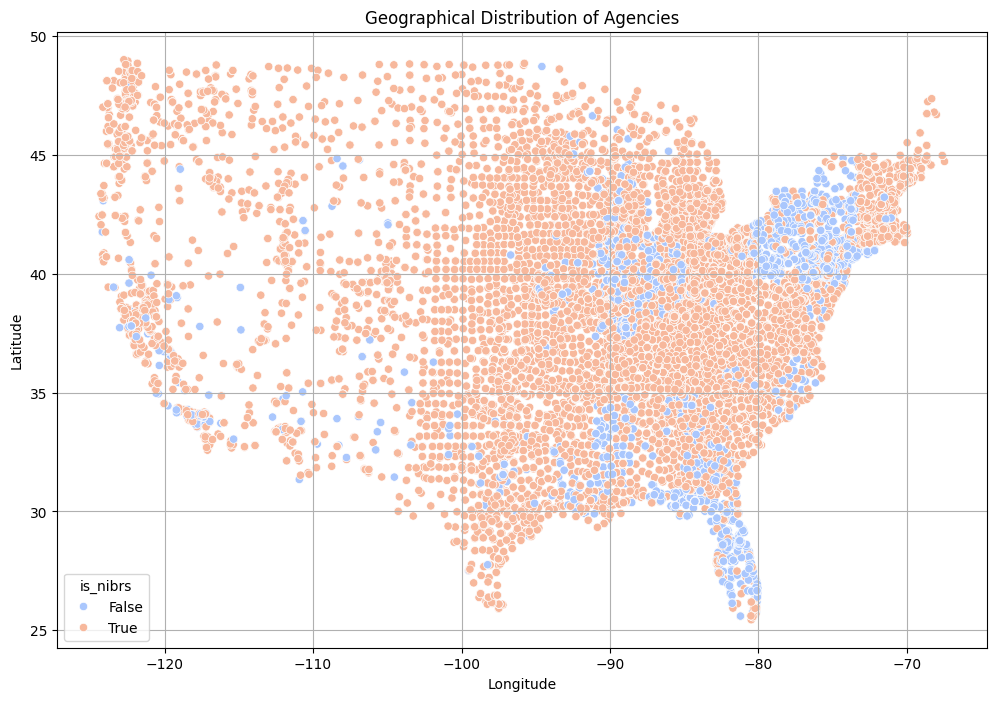

In [74]:
# Visualize agency locations by NIBRS status
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', hue='is_nibrs', data=data, palette='coolwarm')
plt.title("Geographical Distribution of Agencies")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

### 🗺️ Geographical Distribution of NIBRS Compliance

The scatter plot shows the spatial distribution of law enforcement agencies across the U.S., color-coded by their NIBRS compliance status.

**Key Observations:**
- Agencies in the **Eastern and Midwestern U.S.** show higher compliance with NIBRS standards.
- There are **fewer compliant agencies in the Western and Southern regions**, possibly due to infrastructure or policy adoption delays.
- The distribution suggests that **geography is a significant factor** in NIBRS adoption — supporting why `latitude` and `longitude` were top features in the model.

This visualization provides geographical context to support the model's use of location data in predicting NIBRS compliance.

## NIBRS Adoption Over Time

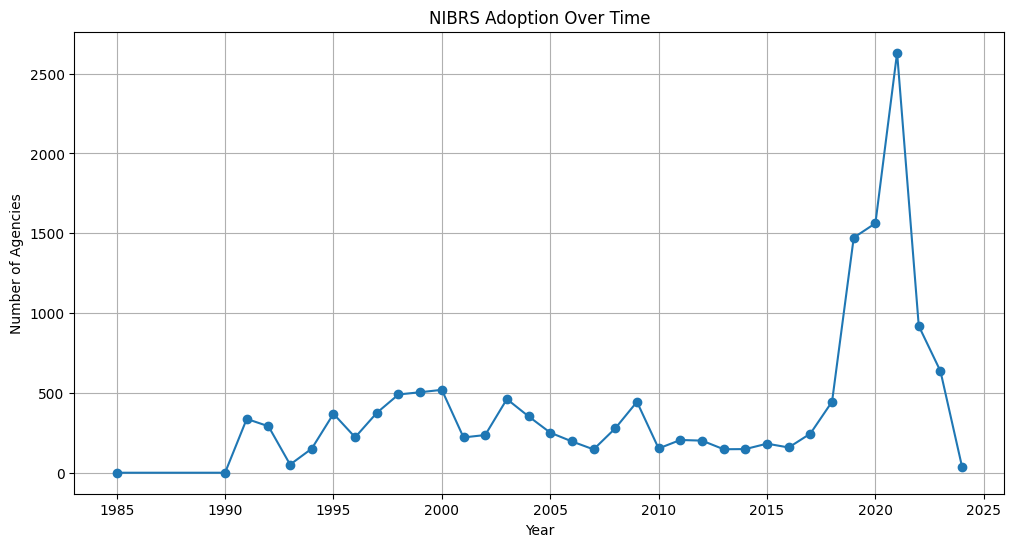

In [75]:
# Line plot showing how many agencies adopted NIBRS by year
plt.figure(figsize=(12, 6))
nibrs_trend = data['nibrs_start_year'].value_counts().sort_index()
plt.plot(nibrs_trend.index, nibrs_trend.values, marker='o')
plt.title("NIBRS Adoption Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Agencies")
plt.grid(True)
plt.show()

### 📈 NIBRS Adoption Trend Over Time

The line plot shows the number of agencies adopting NIBRS per year:

**Key Insights:**
- Adoption remained low until the mid-2010s, fluctuating between 100–500 agencies/year.
- A **sharp surge occurred between 2018–2021**, reaching its peak in 2021.
- This aligns with the **FBI’s mandatory NIBRS transition deadline** set for January 1, 2021.
- Post-2021, the decline likely reflects data saturation (most agencies have already adopted NIBRS).

✅ This plot clearly demonstrates how policy decisions directly influence adoption patterns — a factor our model likely captured via date- and state-related features.

## Cross-Validation Score

In [76]:
# Cross-validation to validate stability of Logistic Regression
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("LogReg CV ROC AUC:", cross_val_score(log_reg, X_resampled, y_resampled, cv=cv, scoring='roc_auc').mean())

LogReg CV ROC AUC: 0.7053188008277708


### 🔁 Cross-Validation: Logistic Regression

To assess the stability and generalizability of the Logistic Regression model, we performed 5-fold Stratified Cross-Validation using ROC AUC as the evaluation metric.

**Result:**
- **Average ROC AUC Score:** 0.7053

**Interpretation:**
- The model has moderate discriminatory power.
- It performs better than random, but not as well as Decision Tree or Random Forest.
- This reinforces that **Logistic Regression is better suited as a baseline model**, and more complex models are needed to capture patterns in the data.

✅ This cross-validation confirms that our top-performing models (Tree-based) are not just overfitting to the training set.

In [77]:
import joblib

# Save model and scaler after training
joblib.dump(forest, "best_model.pkl")
joblib.dump(scaler_std, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")


['label_encoders.pkl']

In [78]:
from collections import Counter
print(Counter(y_train))


Counter({True: 12026, False: 3270})
